In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from fbprophet import Prophet

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Introduction

This `kaggle` competition consists of two main data sources:

* `train.csv` and
* `stores.csv`

For the submission a third data source is provided, `test.csv` which is to be used for the scoring process. 
In this notebook we ignore this last file.
Furthermore, due to time constrains and simplicity the additional data available in `stores.csv` is ignored as well.

# Sales data

Loading the sales data from `train.csv`.

In [2]:
def load_data(filename):
    """
    Loading data and applying types casting.
    
    This way it is easier to have the same data both for the training and testing data
    """
    data_dtypes = {
    'Open': 'category', 
    'Promo': 'category', 
    'StateHoliday': 'category',
    'SchoolHoliday': 'category'
    }
    res = pd.read_csv(
        filename, parse_dates=['Date'], dtype=data_dtypes)
    res.sort_values(by='Date', inplace=True)
    return res

In [3]:
train = load_data('../data/raw/train.csv')

# The test data set won't be used in this notebook
# test = load_data('../data/raw/test.csv')

# Add dates related features
train['Month'] = train.Date.dt.month
train['WeekOfYear'] = train.Date.dt.weekofyear

# Daily sales per customer
train['SalesPerCustomer'] = train.Sales / train.Customers

print("Loaded {} entries".format(train.shape[0]))

train.head(10)

Loaded 1017209 entries


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,WeekOfYear,SalesPerCustomer
1017208,1115,2,2013-01-01,0,0,0,0,a,1,1,1,NaN
1016473,379,2,2013-01-01,0,0,0,0,a,1,1,1,NaN
1016472,378,2,2013-01-01,0,0,0,0,a,1,1,1,NaN
1016471,377,2,2013-01-01,0,0,0,0,a,1,1,1,NaN
1016470,376,2,2013-01-01,0,0,0,0,a,1,1,1,NaN
1016469,375,2,2013-01-01,0,0,0,0,a,1,1,1,NaN
1016468,374,2,2013-01-01,0,0,0,0,a,1,1,1,NaN
1016467,373,2,2013-01-01,0,0,0,0,a,1,1,1,NaN
1016466,372,2,2013-01-01,0,0,0,0,a,1,1,1,NaN
1016465,371,2,2013-01-01,0,0,0,0,a,1,1,1,NaN


When a store is closed, it should have no sales. Is it the case?

In [4]:
train[(train.Open=='0') & (train.Sales > 0)].shape[0]

0

Indeed! What about stores which were open but had no sales:

In [5]:
train[(train.Open=='1') & (train.Sales == 0)].shape[0]

54

## Stay with open stores that had sales

Interestingly, there are couple of such cases. For the time being we shall ignore them.

In [6]:
train = train[(train.Open=='1') & (train.Sales > 0)]

At the end if the store is closed, the predict sales should be 0.

## EDA

Before diving into the prediction itself, let us have a brief Exploratory Data Analysis.

### Monthly level

First, we look at the average monthly behavior.

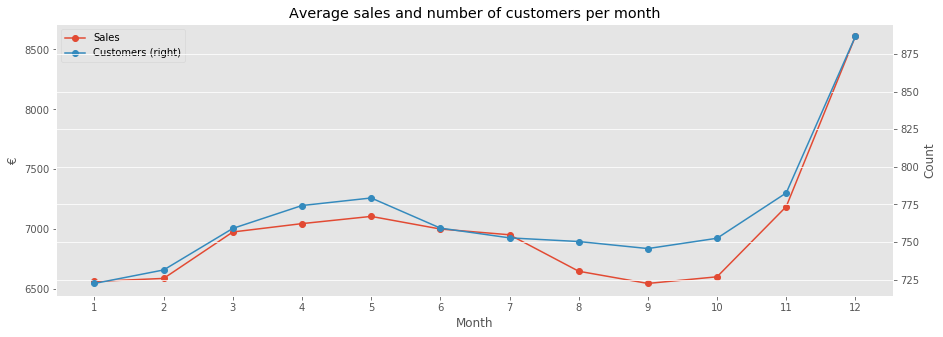

In [7]:
ax = train.groupby('Month')[['Sales', 'Customers']].mean().plot(secondary_y=['Customers'], figsize=(15,5), marker='o')
ax.set_ylabel('€')
ax.right_ax.set_ylabel('Count')
ax.set_xticks(range(1,13))
plt.title('Average sales and number of customers per month');

No surprise, in Decembers (during Christmas times) the stores have more customers and make more sales.
Worthy pointing, that in April/May there is another, much smaller, peak.

What about the average spend per customer?

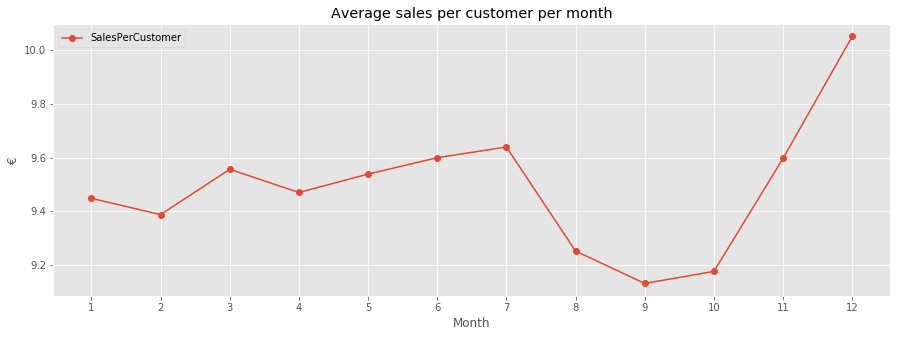

In [8]:
ax = train.groupby('Month')[['SalesPerCustomer']].mean().plot(figsize=(15,5), marker='o')
ax.set_ylabel('€')
ax.set_xticks(range(1,13))
plt.title('Average sales per customer per month');

Again, around Christmas times, customers spend the most. 
However, the other peaks are in March and July.

### Day of the week

Let us check how does the average spend per customer changes over the days of the week

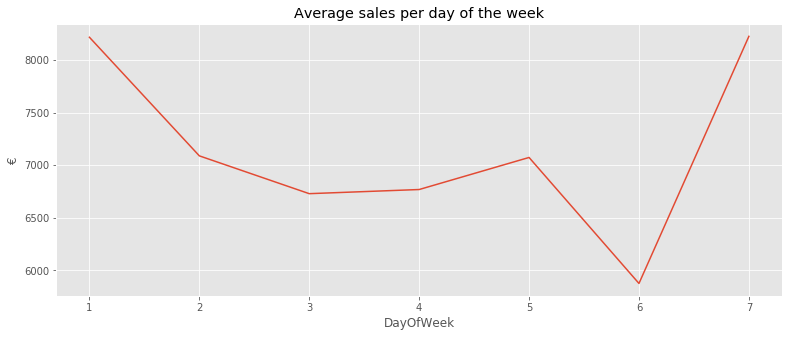

In [9]:
train.groupby(['DayOfWeek'])['Sales'].mean().plot(figsize=(13,5))
plt.title('Average sales per day of the week')
plt.ylabel('€');

Mondays and Sundays present best average sales and Saturday is the weakest.

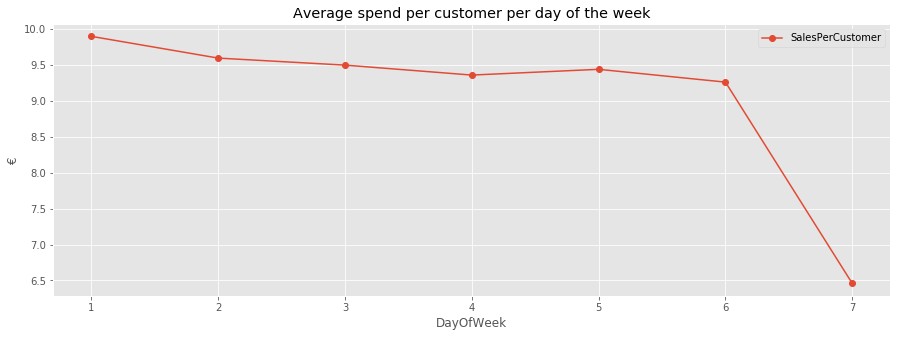

In [10]:
ax = train.groupby('DayOfWeek')[['SalesPerCustomer']].mean().plot(figsize=(15,5), marker='o')
ax.set_ylabel('€')
plt.title('Average spend per customer per day of the week');

From Monday peak of almost 10€ to as low as ~6.5€ on Sundays. Following, for every day of the week, the average spend per customer depending on the month.

Following set of plots visualizes the behavior of the average sales per customer depending on the day of the week and the month of the year.

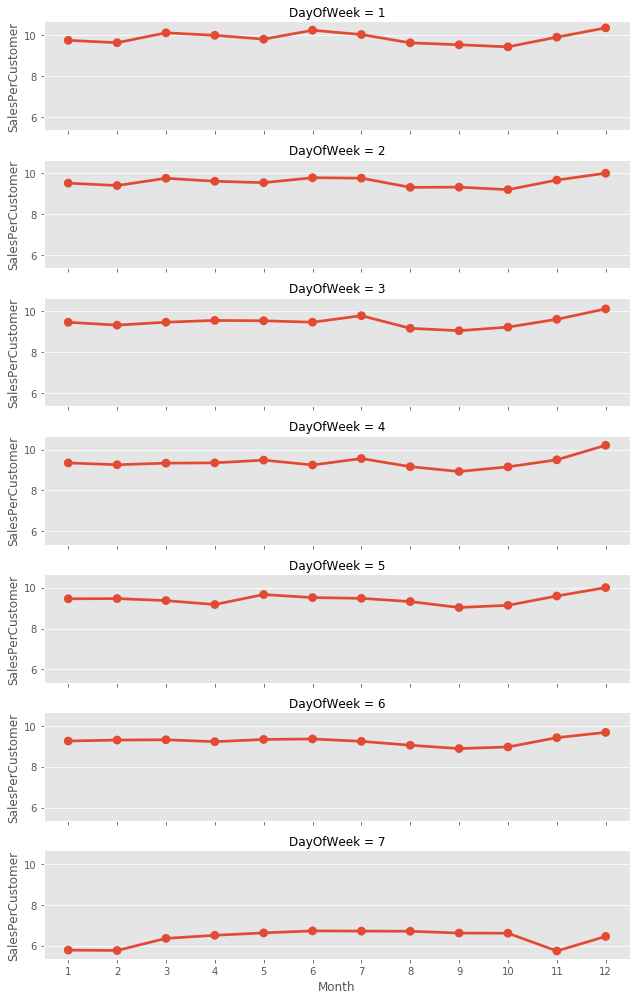

In [11]:
tmp = train.groupby(['Month', 'DayOfWeek'])['SalesPerCustomer'].mean().reset_index()
sns.factorplot(data = tmp, x = 'Month', y = "SalesPerCustomer", row = 'DayOfWeek',
              size=2, aspect=4.5);

Most visible: Sundays are the weakest on January, February and November.

### Sales per week of the year

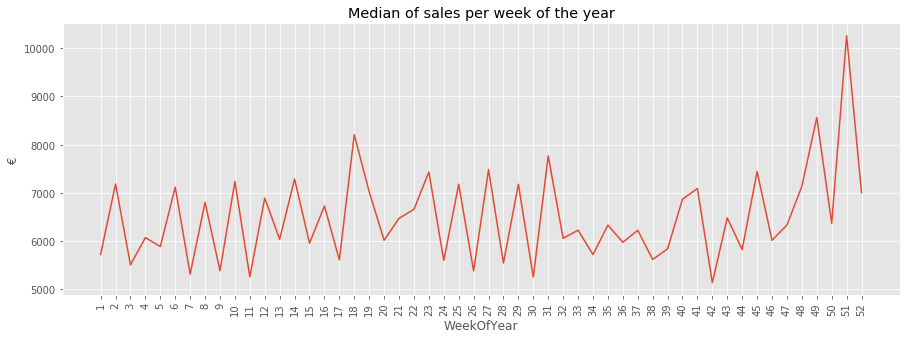

In [12]:
train.groupby('WeekOfYear')['Sales'].median().plot(figsize=(15,5), xticks=np.arange(1,53), rot=90)
plt.title('Median of sales per week of the year')
plt.ylabel('€');

* Week 51 has the strongest Median
* The alternation pattern is interesting and worthy further investigation

### Misc

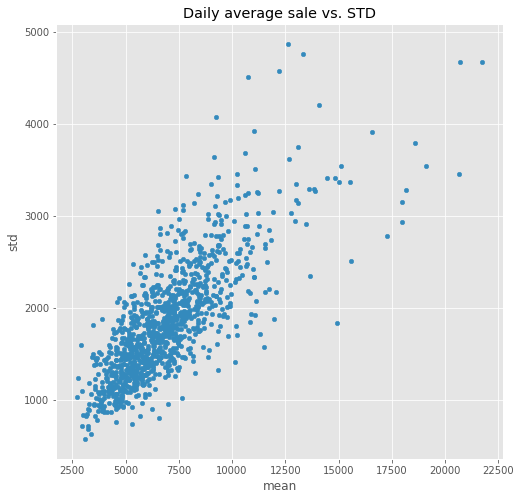

In [13]:
tmp = train.groupby(['Store'])['Sales'].agg(['mean', 'std']).sort_values('mean')
tmp.plot.scatter('mean', 'std', figsize=(8,8))
plt.title('Daily average sale vs. STD');

/Users/drorata/anaconda3/envs/rossmann_store_sales/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


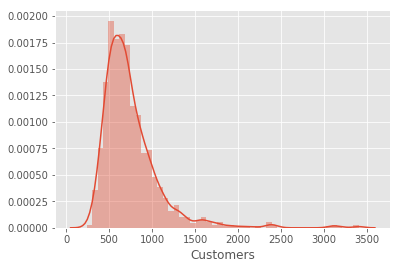

In [14]:
sns.distplot(train.groupby(['Store'])['Customers'].mean())

# Prediction using Facebook's Prophet

An easy getting started with time series analysis is [Facebook's Prophet](https://research.fb.com/prophet-forecasting-at-scale/).

In [15]:
def train_data_store(storeID, df=train):
    """
    For a given store, return the daily sales 
    formated for prophet
    """
    condition = df.Store==storeID
    data = df[condition][['Date', 'Sales']].rename(
        columns={ # Rename columns to meet needs of the prophet
            'Date': 'ds',
            'Sales': 'y'
        }
    ).sort_values('ds')
    return data

In [16]:
def RMSPE(y, yhat):
    """
    Compute the score as per the definition on 
    https://www.kaggle.com/c/rossmann-store-sales#evaluation
    """
    return np.sqrt(((y - yhat).div(y) ** 2).sum() / len(y))

## Fitting the prophet

In [17]:
def fit_prophet_for_store(storeID=1, train_ratio=0.8, holidays=None):
    """
    Given a store ID, take ~`train_traio` of the data
    for training of the prophet
    """
    data = train_data_store(storeID)
    
    N = int(np.floor(train_ratio * data.shape[0]))
    print("Training on {}% of the data = {} entries".format(
        train_ratio, N
    ))
    
    prophet = Prophet(interval_width = 0.95, holidays = holidays)
    prophet.fit(data[:N])
    
    return prophet, data, N

### Example

In [18]:
storeID=1

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Training on 0.9% of the data = 702 entries


/Users/drorata/anaconda3/envs/rossmann_store_sales/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


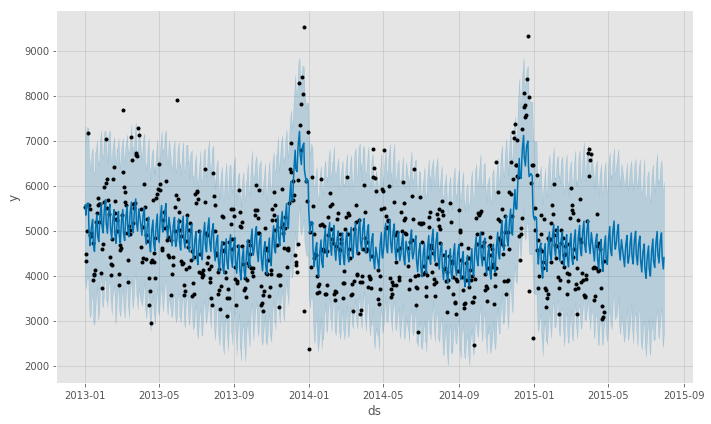

In [19]:
prophet, data, N = fit_prophet_for_store(storeID=storeID, train_ratio=0.9)
prophet.plot(prophet.predict(data));

In [20]:
RMSPE(data[N:]['y'].values, prophet.predict(data[N:])['yhat'])

0.16753267953924883

## Factor in the holidays

Extract the dates of state and school holidays and format them in a DataFrame adhering to the need of the prophet

In [21]:
stateHolidaysDates = train[train.StateHoliday.isin(['a', 'b', 'c'])]['Date'].unique()
schoolHolidaysDates = train[train.SchoolHoliday=='1']['Date'].unique()
holidays = pd.concat(
    [
        pd.DataFrame({
            'holiday': 'state',
            'ds': stateHolidaysDates
        }),
        pd.DataFrame({
            'holiday': 'school',
            'ds': schoolHolidaysDates
        })
    ]
)
holidays.sample(5)

,ds,holiday
296,2014-08-02,school
472,2015-07-27,school
425,2015-04-10,school
448,2015-06-04,school
419,2015-04-04,school


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Training on 0.9% of the data = 702 entries


/Users/drorata/anaconda3/envs/rossmann_store_sales/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


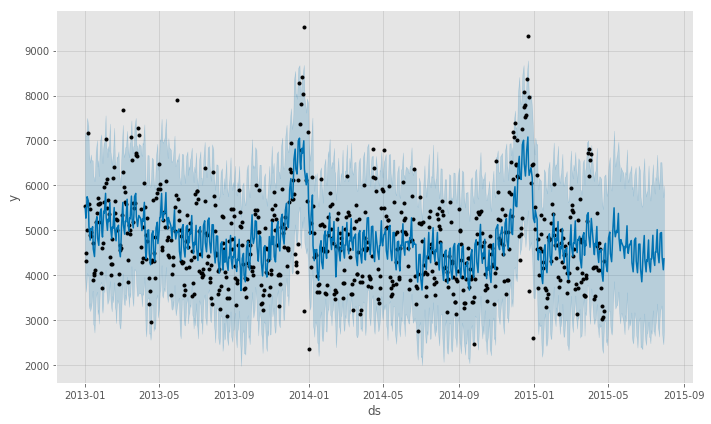

In [22]:
prophet, data, N = fit_prophet_for_store(storeID=storeID, train_ratio=0.9, holidays=holidays)
prophet.plot(prophet.predict(data));

In [23]:
RMSPE(data[N:]['y'].values, prophet.predict(data[N:])['yhat'])

0.1671235940107355

# Conclusion

This notebook is a brief attempt on the forecasting of sales per Rossmann shops.
Very naive approach using only part of the data (ignoring promotions and competitors factors as described in `stores.csv`) yields initial reasonable results.